<a href="https://colab.research.google.com/github/alyaa999/NLP_Back/blob/main/last_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow import keras

# Define the CTCLayer class
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


# Load the model with the custom layer
model = load_model('/content/sample_data/model2.h5', custom_objects={'CTCLayer': CTCLayer})
model.summary()


Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 128, 32, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 32, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 64, 16, 32)           0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 64, 16, 64)           18496     ['pool1[0][0]']               
                                                                             

In [ ]:
!wget -q https://git.io/J0fjL -O IAM_Words.zip
!unzip -qq IAM_Words.zip
!
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

In [112]:
base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)


g07-003a-01-02 ok 152 819 1063 95 43 INO OF



In [ ]:


split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples

)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")
base_image_path = os.path.join(base_path, "words")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823
Maximum length:  21
Vocab size:  78


['or',
 'unable',
 'of',
 'was',
 'plank',
 'Europe',
 ',',
 'sunlight',
 'three',
 'of']

In [ ]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)

In [ ]:

def prepare_dataset_custom(img_paths_3):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths_3)).map(
        preprocess_image, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)



In [ ]:

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


In [ ]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

img_paths_3 = ["/content/sample_data/WhatsApp Image 2024-05-18 at 3.09.55 PM.jpeg","/content/sample_data/WhatsApp Image 2024-05-18 at 3.09.55 PM.jpeg"]
custom_ds = prepare_dataset_custom(img_paths_3)
custom_ds

<_PrefetchDataset element_spec=TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None)>

In [ ]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


len is :  2
batch img shape:  (128, 32, 1)
batch img shape:  (128, 32, 1)
1/1 [==============================] - 0s 83ms/step
['joohiubhbo/', 'joohiubhbo/']


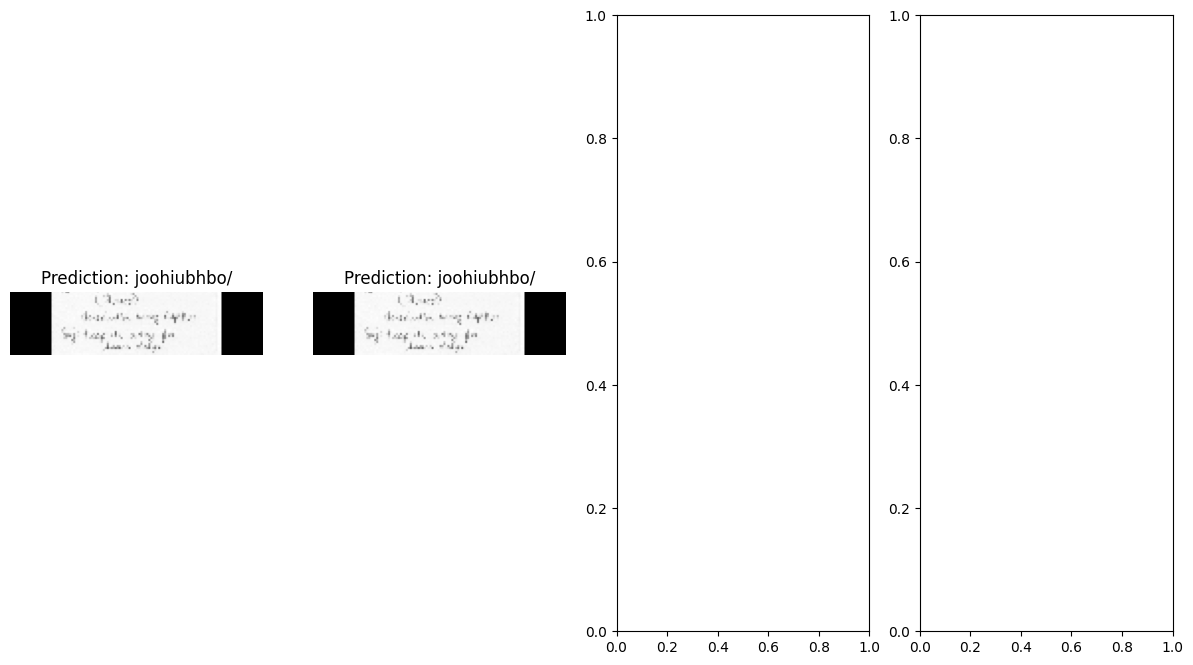

In [ ]:
for batch in custom_ds.take(1):
    # print(batch["label"])
    # print(batch)
    # batch_images = batch["image"]
    print("len is : ",len(batch))
    print("batch img shape: ",batch[0].shape)
    print("batch img shape: ",batch[1].shape)

    _, ax = plt.subplots(1, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch)
    pred_texts = decode_batch_predictions(preds)
    print(pred_texts)

    for i in range(2):
        img = batch[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i].imshow(img, cmap="gray")
        ax[i].set_title(title)
        ax[i].axis("off")

plt.show()
